In [3]:
!pip install imutils > /dev/null
!pip install cython > /dev/null

# Install pycocotools from this GitHub rep
!pip install git+"https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI" > /dev/null


  Running command git clone --filter=blob:none --quiet https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-20qp624d


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
TOP_PATH = ('/kaggle/input/coco-2017-dataset/coco2017')
TRAIN_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/train2017')
VAL_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/val2017')
ANNOTATIONS_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/annotations')
TEST_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/test2017')
WORKING_DIR = ('/kaggle/working')
MASK_TRAIN_DIR = ('/kaggle/working/mask_train')
MASK_VAL_DIR =('/kaggle/working/mask_val')
MASK_TRAIN_SMOOTH_DIR = ('/kaggle/working/mask_train_smooth')

In [6]:
import os
os.chdir(WORKING_DIR)

In [7]:
# Import all the libraries
import numpy as np
import cv2
import requests
import os
import imutils
from PIL import Image
from tqdm.notebook import tqdm
########3
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import skimage.io as io
import random
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from random import shuffle

from PIL import Image 
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *



# Load the TensorBoard notebook extension.

%load_ext tensorboard


from datetime import datetime

seed = 2025

random.seed = seed
np.random.seed = seed

2025-06-22 00:37:05.468248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750552625.880665      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750552625.990205      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
os.listdir(ANNOTATIONS_PATH)

['person_keypoints_train2017.json',
 'instances_val2017.json',
 'instances_train2017.json',
 'person_keypoints_val2017.json',
 'captions_train2017.json',
 'captions_val2017.json']

In [9]:
ANNOTATION_FILE_VAL = (ANNOTATIONS_PATH + '/instances_val2017.json')
ANNOTATION_FILE_TRAIN = (ANNOTATIONS_PATH + '/instances_train2017.json')

In [10]:
coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds() # Get all Categories ('horse','human' etc...)
imgIds_train = coco_train.getImgIds() # Get all image ID's (dict with path and annotations)
imgDict_train = coco_train.loadImgs(imgIds_train) # Func to load images from path
print(len(imgIds_train) , len(catIds_train))

loading annotations into memory...
Done (t=19.89s)
creating index...
index created!
118287 80


In [11]:
print(catIds_train,end='')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]

In [12]:
coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds()
imgIds_val = coco_val.getImgIds()
imgDict_val = coco_val.loadImgs(imgIds_val)
print(len(imgIds_val) , len(catIds_val))

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
5000 80


In [13]:
shuffle(imgIds_train) # randoms shuffling
shuffle(imgIds_val) # random shuffling

# take less samples so that training period is less
imgIds_train = imgIds_train[0:60000]
imgIds_val = imgIds_val[0:5000]
# imgIds_train = imgIds_train[0:3000]
# imgIds_val = imgIds_val[0:500]


In [14]:
# used to format string according to naming convention of the files
print("{0:012d}.jpg".format(12345678))
print("{0:012d}.jpg".format(4))

000012345678.jpg
000000000004.jpg


In [15]:
train_images = ["COCO_train2014_{0:012d}.jpg".format(ids) for ids in imgIds_train]
# keep aside train and val image names
val_images = ["COCO_val2014_{0:012d}.jpg".format(ids) for ids in imgIds_val]
print(len(train_images) , len(val_images))

60000 5000


In [16]:
os.chdir(WORKING_DIR)

In [17]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from pycocotools.coco import COCO


# Create directories to save masks
os.makedirs(MASK_TRAIN_DIR, exist_ok=True)
os.makedirs(MASK_VAL_DIR, exist_ok=True)

# Load annotations
coco_train = COCO(os.path.join(ANNOTATIONS_PATH, 'instances_train2017.json'))
coco_val = COCO(os.path.join(ANNOTATIONS_PATH, 'instances_val2017.json'))

# Get category info and class mappings
cat_ids = coco_train.getCatIds()
cat_id_to_label = {cat_id: idx + 1 for idx, cat_id in enumerate(cat_ids)}  # label 0 is background

# Function to generate and save masks
def generate_multiclass_masks(coco, img_ids, save_dir):
    for img_id in tqdm(img_ids):
        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id, iscrowd=0))
        if len(anns) == 0:
            continue
        
        img_info = coco.loadImgs(img_id)[0]
        height, width = img_info['height'], img_info['width']
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for ann in anns:
            cat_id = ann['category_id']
            label = cat_id_to_label[cat_id]
            ann_mask = coco.annToMask(ann)
            mask[ann_mask == 1] = label  # overwrite with class label

        # Save mask as PNG
        filename = img_info['file_name'].replace('.jpg', '.png')
        mask_path = os.path.join(save_dir, filename)
        Image.fromarray(mask, mode='L').save(mask_path)

# Generate masks
print("Generating training masks...")
generate_multiclass_masks(coco_train, coco_train.getImgIds(), MASK_TRAIN_DIR)

print("Generating validation masks...")
generate_multiclass_masks(coco_val, coco_val.getImgIds(), MASK_VAL_DIR)


loading annotations into memory...
Done (t=18.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
Generating training masks...


100%|██████████| 118287/118287 [15:06<00:00, 130.56it/s]


Generating validation masks...


100%|██████████| 5000/5000 [00:38<00:00, 130.58it/s]


In [18]:
# !mkdir mask_train

In [19]:
import numpy as np
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import cv2

class COCODataGenerator(Sequence):
    def __init__(self,
                 image_dir,
                 mask_dir,
                 image_filenames,
                 batch_size=16,
                 image_size=(128, 128),
                 n_classes=81,              # 80 classes + background
                 shuffle=True,
                 augment_fn=None,
                 one_hot=True,
                 normalize=True,**kwargs):
        
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.image_size = image_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment_fn = augment_fn
        self.one_hot = one_hot
        self.normalize = normalize
        self.on_epoch_end()
        super().__init__(**kwargs)

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.image_filenames)

    def __getitem__(self, idx):
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        masks = []

        for filename in batch_filenames:
            # Load image and mask
            image_path = os.path.join(self.image_dir, filename)
            mask_path = os.path.join(self.mask_dir, filename.replace(".jpg",".png"))

            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.imread(image_path)[..., ::-1]  # Converts BGR to RGB
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize
            img = cv2.resize(img, self.image_size, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)

            # Optional augmentation
            if self.augment_fn:
                augmented = self.augment_fn(image=img, mask=mask)
                img, mask = augmented['image'], augmented['mask']

            # Normalize image
            if self.normalize:
                img = img / 255.0

            # One-hot encode mask
            if self.one_hot:
                mask = to_categorical(mask, num_classes=self.n_classes)

            images.append(img)
            masks.append(mask)

        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)


In [20]:
# count = 0 
# unfitted_image_dict = []
# for ID in tqdm(imgIds_train):
#     file_path = MASK_TRAIN_DIR+"/{0:012d}.jpg".format(ID)
#     # basic functionality is to take all masks, and create a unified mask
#     sampleImgIds = coco_train.getImgIds(imgIds = [ID])
#     sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]
#     # take all annotations for all categories
#     annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], 
#                                 catIds=catIds_train, 
#                                 iscrowd=0)
#     anns = coco_train.loadAnns(annIds)
#     print(anns)
#     break
#     # separating images with background as the only mask
#     if len(anns)==0:
#         unfitted_image_dict.append(sampleImgDict)
#     else:
#         mask = coco_train.annToMask(anns[0])
#         # unify all the masks provided
#         for i in (range(len(anns))):
#             mask = mask | coco_train.annToMask(anns[i])
#         mask = Image.fromarray(mask * 255 , mode = "L")
#         # save the mask
#         mask.save(file_path)
#         count = count + 1
# print(count)

In [21]:
train_mask_filenames = os.listdir(MASK_TRAIN_DIR)

# Derive image filenames from mask filenames
train_image_filenames = [f.replace('.png', '.jpg') for f in train_mask_filenames]

In [22]:
train_generator = COCODataGenerator(
    image_dir='/kaggle/input/coco-2017-dataset/coco2017/train2017',
    mask_dir=MASK_TRAIN_DIR,
    image_filenames=train_image_filenames,
    batch_size=32,
    image_size=(128, 128),
    n_classes=81,
    shuffle=True,
    one_hot=True,
    normalize=True
)


In [23]:
val_mask_filenames = os.listdir(MASK_VAL_DIR)

# Derive image filenames from mask filenames

val_image_filenames = [f.replace('.png', '.jpg') for f in val_mask_filenames]


In [24]:
val_generator = COCODataGenerator(
    image_dir='/kaggle/input/coco-2017-dataset/coco2017/val2017',
    mask_dir='/kaggle/working/mask_val',
    image_filenames=val_image_filenames,
    batch_size=32,
    image_size=(128, 128),
    n_classes=81,
    shuffle=False,
    one_hot=True,
    normalize=True
)

In [25]:
# Get the first batch (index 0)
x_val_batch, y_val_batch = val_generator[0]

print("Image batch shape:", x_val_batch.shape)  # (batch_size, height, width, 3)
print("Mask batch shape:", y_val_batch.shape)   # (batch_size, height, width, n_classes)


Image batch shape: (32, 128, 128, 3)
Mask batch shape: (32, 128, 128, 81)


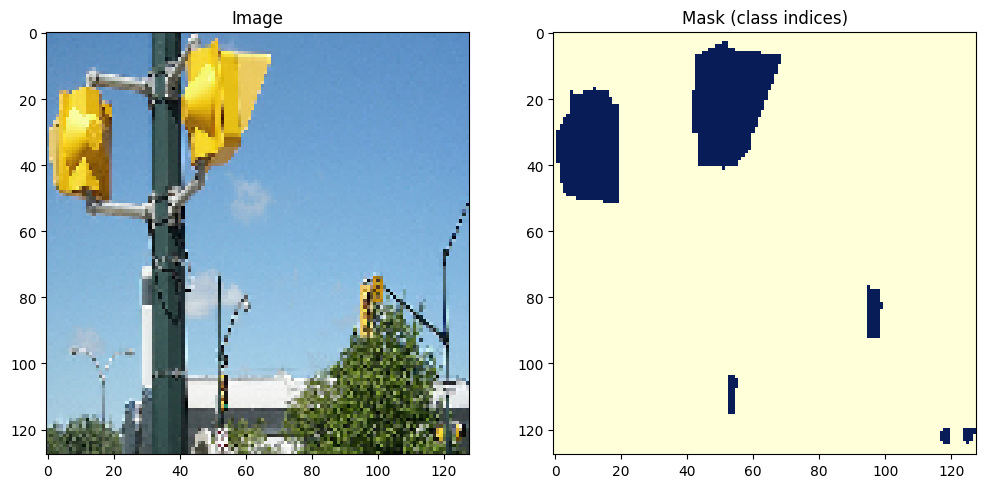

In [26]:
# Index into the batch, e.g., get the first image and mask from the first batch
x_img = x_val_batch[0]
y_mask = y_val_batch[0]

# If you want to visualize the original class labels from the one-hot mask
import numpy as np
y_mask_labels = np.argmax(y_mask, axis=-1)  # shape: (height, width)

# Or visualize with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(x_img)
plt.subplot(1, 2, 2)
plt.title("Mask (class indices)")
plt.imshow(y_mask_labels,cmap = "YlGnBu")
plt.show()


In [27]:
x_train_batch, y_train_batch = train_generator[5]

print("Image batch shape:", x_train_batch.shape)  # (batch_size, height, width, 3)
print("Mask batch shape:", y_train_batch.shape)   # (batch_size, height, width, n_classes)


Image batch shape: (32, 128, 128, 3)
Mask batch shape: (32, 128, 128, 81)


In [28]:
import matplotlib.pyplot as plt

def visualize_batch(generator, num_samples=3):
    x_batch, y_batch = generator[0]  # Get a batch
    for i in range(num_samples):
        img = x_batch[i]
        mask = y_batch[i]
        
        plt.figure(figsize=(8, 4))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        # If multiclass, use argmax
        plt.subplot(1, 2, 2)
        if mask.shape[-1] > 1:
            plt.imshow(mask.argmax(axis=-1), cmap="jet")
        else:
            plt.imshow(mask.squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


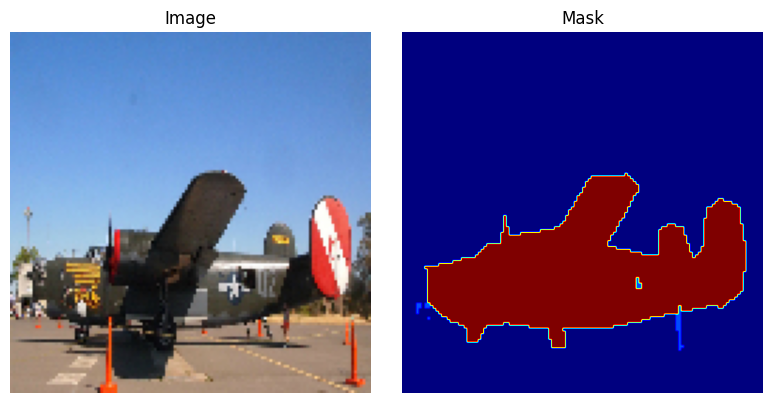

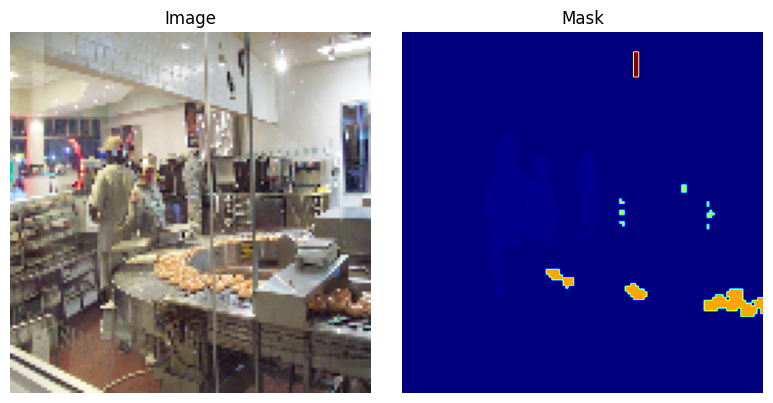

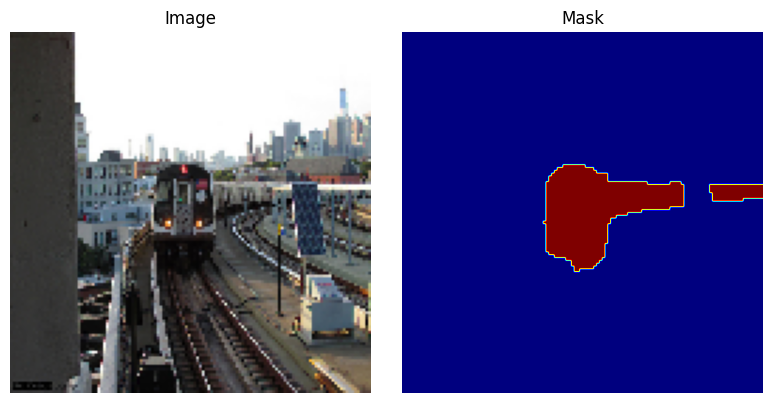

In [29]:
visualize_batch(train_generator, num_samples=3)

In [30]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

n_classes = 81  # For COCO 2017 (80 + 1 background)
image_size = 128

model_in = Input(shape=(image_size, image_size, 3))

# Downsampling path
conv1 = BatchNormalization()(model_in)
conv1 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv1)
conv1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
down1 = MaxPooling2D()(conv1)

conv2 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(down1)
conv2 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
down2 = MaxPooling2D()(conv2)

conv3 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(down2)
conv3 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
down3 = MaxPooling2D()(conv3)

conv4 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(down3)
conv4 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
down4 = MaxPooling2D()(conv4)

# Bottleneck
conv5 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(down4)
conv5 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv5)

# Upsampling path
conv6 = BatchNormalization()(conv5)
conv6 = Conv2DTranspose(512, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv6)
conv6 = Activation('relu')(conv6)
conv6 = concatenate([conv4, conv6])
conv6 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv6)
conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv6)

conv7 = BatchNormalization()(conv6)
conv7 = Activation('relu')(conv7)
conv7 = Conv2DTranspose(256, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv7)
conv7 = concatenate([conv3, conv7])
conv7 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv7)
conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv7)

conv8 = BatchNormalization()(conv7)
conv8 = Activation('relu')(conv8)
conv8 = Conv2DTranspose(128, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv8)
conv8 = concatenate([conv2, conv8])
conv8 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv8)
conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv8)

conv9 = BatchNormalization()(conv8)
conv9 = Activation('relu')(conv9)
conv9 = Conv2DTranspose(64, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv9)
conv9 = concatenate([conv1, conv9])
conv9 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv9)

# Output layer
output = Conv2D(n_classes, 1, activation='softmax', padding='same')(conv9)

model = Model(inputs=model_in, outputs=output)


I0000 00:00:1750553637.450321      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750553637.451043      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [31]:
class MeanIoUMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MeanIoUMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return self.iou.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.iou.result()

    def reset_states(self):
        return self.iou.reset_states()


In [32]:
from keras.optimizers import AdamW

model.compile(
    optimizer=AdamW(),
    loss='categorical_crossentropy',
   metrics=['accuracy', MeanIoUMetric(num_classes=n_classes)]
)


In [33]:
batch_size = 32

In [34]:
len(train_generator)

3665

In [34]:
# limited_filenames = train_image_filenames[:4679]  # Replace with your list


In [35]:
# train_generator = COCODataGenerator(
#     image_dir='/kaggle/input/coco-2017-dataset/coco2017/train2017',
#     mask_dir='/kaggle/working/mask_train',
#     image_filenames=limited_filenames,
#     batch_size=8,
#     image_size=(256, 256),
#     n_classes=81,
#     shuffle=True,
#     augment_fn=None,
#     one_hot=True,
#     normalize=True
# )


In [71]:
steps_per_epoch = int(np.ceil(len(train_image_filenames)/16))

from tensorflow.keras.callbacks import ModelCheckpoint


# Update callbacks if needed (optional)
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/unet_adamw_multi_class.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)

logdir = WORKING_DIR+"/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Resume training
history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=steps_per_epoch,
                           # <- Important: Resume from epoch 10
                    epochs=5,               # <- Final epoch number after continuing
                    callbacks=[tensorboard_callback, checkpoint],
                    verbose=1,batch_size=16)

Epoch 1/5
6024/7330 ━━━━━━━━━━━━━━━━━━━━ 9:22 431ms/step - accuracy: 0.7149 - loss: 1.3721 - mean_iou: 0.0129

E0000 00:00:1750318222.495979     167 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750318222.715849     167 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


7330/7330 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7172 - loss: 1.3498 - mean_iou: 0.0141
Epoch 1: val_loss improved from inf to 1.09837, saving model to /kaggle/working/unet_adamw_multi_class.h5
7330/7330 ━━━━━━━━━━━━━━━━━━━━ 3412s 459ms/step - accuracy: 0.7172 - loss: 1.3498 - mean_iou: 0.0141 - val_accuracy: 0.7415 - val_loss: 1.0984 - val_mean_iou: 0.0376
Epoch 2/5
7330/7330 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7555 - loss: 1.0283 - mean_iou: 0.0445
Epoch 2: val_loss improved from 1.09837 to 1.09431, saving model to /kaggle/working/unet_adamw_multi_class.h5
7330/7330 ━━━━━━━━━━━━━━━━━━━━ 2742s 374ms/step - accuracy: 0.7555 - loss: 1.0283 - mean_iou: 0.0445 - val_accuracy: 0.7560 - val_loss: 1.0943 - val_mean_iou: 0.0523
Epoch 3/5
7330/7330 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7748 - loss: 0.9053 - mean_iou: 0.0719
Epoch 3: val_loss improved from 1.09431 to 0.94036, saving model to /kaggle/working/unet_adamw_multi_class.h5
7330/7330 ━━━━━━━━━━━━━━━━━━

> this is model trained on whole data for 5 epochs , batch_size = 16 , image_size = 128, optimizer = AdamW() and metrics = accuracy ,MeanIoU

In [72]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

n_classes = 81  # Update if different
image_size = (128, 128)  # Make sure this matches training

def preprocess_image(image_path, target_size=image_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    image = tf.expand_dims(image, axis=0)  # (1, H, W, 3)
    return image

# Load model with custom metric
model = tf.keras.models.load_model(
    "/kaggle/input/unet_multi/tensorflow2/default/1/unet_adamw_multi_class_9.h5",
    custom_objects={"mean_iou":MeanIoUMetric(num_classes=n_classes)}
)

# Predict on a test image
# image_path = "/kaggle/input/image-to-test/0_w1s81z-Q72obhE_z.png"

# x = preprocess_image(image_path)
x , y = val_generator[91]

# Monte Carlo sampling for uncertainty (optional)
y_probas = np.stack([model(x, training=True) for _ in range(50)])  # (10, 1, H, W, C)
y_pred = y_probas.mean(axis=0)  # (1, H, W, C)

# Convert probabilities to class labels
pred_mask = np.argmax(y_pred, axis=-1)[0]  # (H, W)

# Optional: Assign colors to each class for visualization
def decode_segmentation_mask(mask, n_classes=81):
    colors = np.random.randint(0, 255, size=(n_classes, 3), dtype=np.uint8)
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for c in range(n_classes):
        color_mask[mask == c] = colors[c]
    return color_mask

# Visualize
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(x[0])
plt.title("Input Image")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 2)
color_mask = decode_segmentation_mask(pred_mask, n_classes=n_classes)
plt.imshow(color_mask)
plt.title("Predicted Segmentation")
plt.axis('off')

# plt.imshow(y[0])

plt.tight_layout()
plt.show()


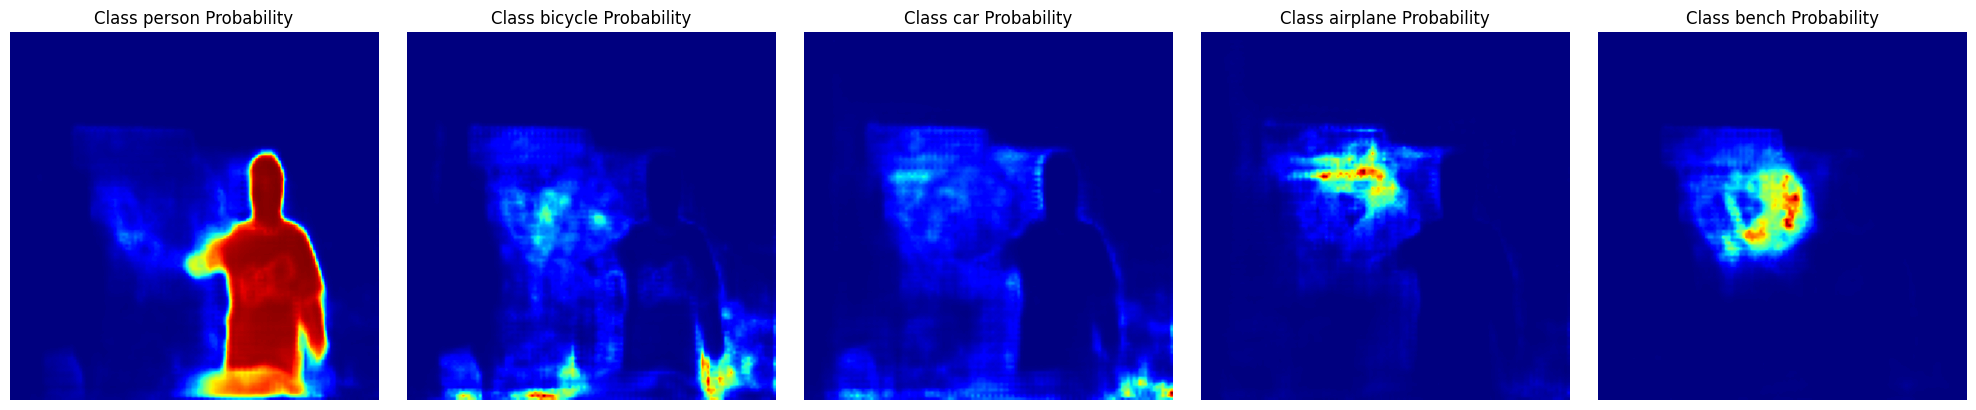

In [93]:
x, y = val_generator[91]
y_probas = np.stack([model(x, training=True) for _ in range(50)])
y_pred = y_probas.mean(axis=0)

# ✅ Add this to visualize probabilities for 5 classes
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, class_id in enumerate([1, 2, 3, 5, 15]):  # Pick any class indices
    axes[i].imshow(y_pred[0, :, :, class_id], cmap="jet")
    cat_info = coco_val.loadCats(class_id)[0]
    cat_name = cat_info['name']
    axes[i].set_title(f"Class {cat_name} Probability")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [35]:
model = tf.keras.models.load_model(
    "/kaggle/input/unet_multi_class_segmentation/tensorflow2/default/1/unet_adamw_multi_class.h5",
    custom_objects={"mean_iou": MeanIoUMetric(num_classes=n_classes)}
)


model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 128, 128, 3)    │             12 │ input_layer_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 128, 128, 64)   │            256 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_24             │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 64)     │              0 │ activation_24[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 64, 64, 128)    │            512 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_25             │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 128)    │              0 │ activation_25[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 32, 32, 256)    │          1,024 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,048,479 (118.44 MB)

 Trainable params: 31,042,711 (118.42 MB)

 Non-trainable params: 5,766 (22.52 KB)

 Optimizer params: 2 (12.00 B)

In [36]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


In [38]:
model.compile(optimizer=AdamW(),
              loss='categorical_crossentropy',
              metrics=['accuracy', MeanIoUMetric(num_classes=n_classes)])
steps_per_epoch = int(np.ceil(len(train_image_filenames)/32))

from tensorflow.keras.callbacks import ModelCheckpoint



# Update callbacks if needed
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/unet_adamw_multi_class_10.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)

logdir = WORKING_DIR + "/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train for more epochs (e.g., continue training)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    initial_epoch = 5,
    epochs=10,  # ← Update this to current total desired epoch count
    callbacks=[tensorboard_callback, checkpoint],
    verbose=1
)


Epoch 6/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3665/3665 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8145 - loss: 0.6808 - mean_iou: 0.1680
Epoch 6: val_loss improved from inf to 0.72138, saving model to /kaggle/working/unet_adamw_multi_class_10.keras
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 4554s 1s/step - accuracy: 0.8145 - loss: 0.6808 - mean_iou: 0.1680 - val_accuracy: 0.8066 - val_loss: 0.7214 - val_mean_iou: 0.1721
Epoch 7/10
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8229 - loss: 0.6369 - mean_iou: 0.1967
Epoch 7: val_loss improved from 0.72138 to 0.69719, saving model to /kaggle/working/unet_adamw_multi_class_10.keras
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 4578s 1s/step - accuracy: 0.8229 - loss: 0.6369 - mean_iou: 0.1967 - val_accuracy: 0.8120 - val_loss: 0.6972 - val_mean_iou: 0.1884
Epoch 8/10
3665/3665 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8326 - loss: 0.5948 - mean_iou: 0.2239
Epoch 8: val_loss improved from 0.69719 to 0.69563, saving model to /kaggle/working/unet_adamw_multi_class_10.keras
3665/3665 ━━━━━━━━━━━━━

In [39]:
model.save("/kaggle/working/unet_adamw_multi_class_10.keras")

In [40]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

n_classes = 81  # Update if different
image_size = (128, 128)  # Make sure this matches training

def preprocess_image(image_path, target_size=image_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    image = tf.expand_dims(image, axis=0)  # (1, H, W, 3)
    return image

# Load model with custom metric
model = tf.keras.models.load_model(
    "/kaggle/input/unet_multi/tensorflow2/default/1/unet_adamw_multi_class_9.h5",
    custom_objects={"mean_iou":MeanIoUMetric(num_classes=n_classes)}
)

# Predict on a test image
# image_path = "/kaggle/input/image-to-test/0_w1s81z-Q72obhE_z.png"

# x = preprocess_image(image_path)
x , y = val_generator[91]

# Monte Carlo sampling for uncertainty (optional)
y_probas = np.stack([model(x, training=True) for _ in range(50)])  # (10, 1, H, W, C)
y_pred = y_probas.mean(axis=0)  # (1, H, W, C)

# Convert probabilities to class labels
pred_mask = np.argmax(y_pred, axis=-1)[0]  # (H, W)

# Optional: Assign colors to each class for visualization
def decode_segmentation_mask(mask, n_classes=81):
    colors = np.random.randint(0, 255, size=(n_classes, 3), dtype=np.uint8)
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for c in range(n_classes):
        color_mask[mask == c] = colors[c]
    return color_mask

# Visualize
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(x[0])
plt.title("Input Image")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 2)
color_mask = decode_segmentation_mask(pred_mask, n_classes=n_classes)
plt.imshow(color_mask)
plt.title("Predicted Segmentation")
plt.axis('off')

# plt.imshow(y[0])

plt.tight_layout()
plt.show()
